FSL Generative adversarial encoder

In [1]:
from google.colab import drive
# drive.mount("/content/gdrive/", force_remount=True)
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
import os
root_path = 'gdrive/My Drive/MINI PROJECT'
# root_path = 'gdrive/My Drive/phd' #/kksFiles'
print(os.getcwd())
os.chdir(root_path)
!ls
#jupyter notebook  --NotebookApp.allow_origin='https://colab.research.google.com'   --port=8888  --NotebookApp.port_retries=0
#Moreover We show that the overall common feature can be taken as dummy class for cluster boundary smoothing which improves the generalization.

/content
 cifar100.ipynb     mammals			    Model
 images_array.pkl   mini-imagenet-cache-test.pkl    Test.ipynb
 labels_array.pkl   mini-imagenet-cache-train.pkl  'transfer Learning.ipynb'
 logs		    mini-imagenet-cache-val.pkl


In [3]:
ls


 cifar100.ipynb     mammals/                        Model/
 images_array.pkl   mini-imagenet-cache-test.pkl    Test.ipynb
 labels_array.pkl   mini-imagenet-cache-train.pkl  'transfer Learning.ipynb'
 logs/              mini-imagenet-cache-val.pkl


In [ ]:
!cd gdrive/Shared with me | ls

gdrive	sample_data
/bin/bash: line 1: cd: too many arguments


In [ ]:
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import os
import keras
import numpy as np
import numpy.random as rng
import random
import tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import  Sequential,load_model, Model, save_model
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers as rg
from tensorflow.keras import callbacks as cb

#import tensorflow_probability as tfp



# Initialization

In [ ]:

lr = 0.001
eps = 1e-12

def W_init(shape,name=None):
    """Initialize weights as in paper"""
    values = rng.normal(loc=0,scale=1e-2,size=shape)
    return K.variable(values,name=name)

def b_init(shape,name=None):
    """Initialize bias as in paper"""
    values=rng.normal(loc=0.5,scale=1e-2,size=shape)
    return K.variable(values,name=name)

#build convnet to use in each siamese 'leg'
def conv_net(dim):
    convnet = Sequential()
    #convnet.add(tf.keras.layers.RandomFlip( mode=HORIZONTAL_AND_VERTICAL, seed=None, **kwargs))
    for i in range(4):

        convnet.add(Conv2D(64,(3,3),padding='same',input_shape=dim))
        convnet.add(BatchNormalization())
        convnet.add(Activation('relu'))
        convnet.add(MaxPooling2D())
    convnet.add(Flatten())
    #convnet.add(Normalization(mean=0., variance=1.))
    return convnet

def make_generator_model(dim):
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3,3),  padding='same', input_shape=dim))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(augmentLayer())
    #model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Conv2D(64,(5,5), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    #model.add(layers.MaxPooling2D(2,2))
    model.add(layers.Conv2D(64,(5,5), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(64,(5,5), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(3, (1,1), padding='same',use_bias=False, activation='sigmoid'))

    #model.add(layers.ReLU())
    return model

from keras.backend import dropout
def minMax1(xx):  # Negative softmax distance measure
    M1=tf.reshape(tf.reduce_max(xx, axis=1),(-1,1))+1
    m1=tf.reshape(tf.reduce_min(xx, axis=1),(-1,1))
    return (xx-m1)/(M1-m1)
def minMax(xx):  # Negative softmax distance measure
    M1=tf.reshape(tf.reduce_max(xx)+0.01)
    m1=tf.reshape(tf.reduce_min(xx))
    return (xx-m1)/(M1-m1)

def normalise(xx):
  global noise
  std = tf.reshape(tf.math.reduce_std(xx,axis=1),(-1,1))
  meanFeature = tf.reshape(tf.reduce_mean(xx,axis=1),(-1,1))
  out_feature = (xx- meanFeature)/std
  return out_feature


def proto_dist(x):  # Negative softmax distance measure
    feature, pred = x
    pred_dist = tf.reduce_sum(pred ** 2, axis=1, keepdims=True)
    feature_dist = tf.reduce_sum(feature ** 2, axis=1, keepdims=True)
    #print(pred_dist.shape);  print(feature_dist.shape)
    dot = tf.matmul(pred, tf.transpose(feature))
    #print(dot.shape)
    return tf.nn.softmax(-(tf.sqrt(pred_dist + tf.transpose(feature_dist) - 2 * dot)))

def cosine_distances(x):
    support, query_img=x
    normalize_a = tf.nn.l2_normalize(support,1)
    normalize_b = tf.nn.l2_normalize(query_img,1)
    distance = tf.matmul(normalize_b, tf.transpose(normalize_a)) #, transpose_b=True
    return distance

def reduce_tensor(x):
    y=tf.reduce_mean(x, axis=1)
    return y

def reshape_query(x):  # reshape query output to  dimention 64*query,1
    y=tf.reshape(x, [-1, tf.shape(x)[-1]])
    return y

def Bias_net(dim):
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size =(3,1),padding ='same', activation ='linear', input_shape = dim))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 8, kernel_size =(3,1),padding ='same', activation ='linear'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters = 1, kernel_size =(3,1), padding ='same', activation='linear'))
    return model


In [ ]:
!ls

gdrive	sample_data


# load dataset

In [ ]:
import pandas as pd
df = pd.read_pickle("mini-imagenet-cache-train.pkl")
x_train=np.array(df['image_data']); y_train = df['class_dict']
#x_train = np.reshape(np.mean(x_train,axis=3),(-1,84,84,1)).astype('float32')
x_train = np.reshape(x_train,(-1,84,84,3)).astype('float32')
# print(x_train.shape)
x_train /=255 #(x_train1-127)/127
print(x_train.shape, len(y_train))
#.....................................................................
df = pd.read_pickle("mini-imagenet-cache-val.pkl")

x_val=df['image_data']; y_val = df['class_dict']
#x_val = np.reshape(np.mean(x_val,axis=3),(-1,84,84,1)).astype('float32')
x_val = np.reshape(x_val,(-1,84,84,3)).astype('float32')
x_val  /=255 #(x_val1-127)/127  # 255
print(x_val.shape, len(y_val))
#..........................................................
df = pd.read_pickle("mini-imagenet-cache-test.pkl")

x_test=df['image_data']; y_test = df['class_dict']
#x_test = np.reshape(np.mean(x_test,axis=3),(-1,84,84,1)).astype('float32')
x_test = np.reshape(x_test,(-1,84,84,3)).astype('float32')
x_test /= 255
#x_test=(x_test1-127)/127
print(x_test.shape, len(y_test))

(38400, 84, 84, 3) 64
(9600, 84, 84, 3) 16
(12000, 84, 84, 3) 20


In [ ]:
# df["image_data"][0]

# # df['class_dict']
# print(38400/64)
print(df['class_dict']['n02110063'][599])

2399


# Data generator general

In [ ]:
random.sample([0,1,2], 1)

[0]

(5, 5, 84, 84, 3) (25, 2, 84, 84, 3) (25, 5) [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


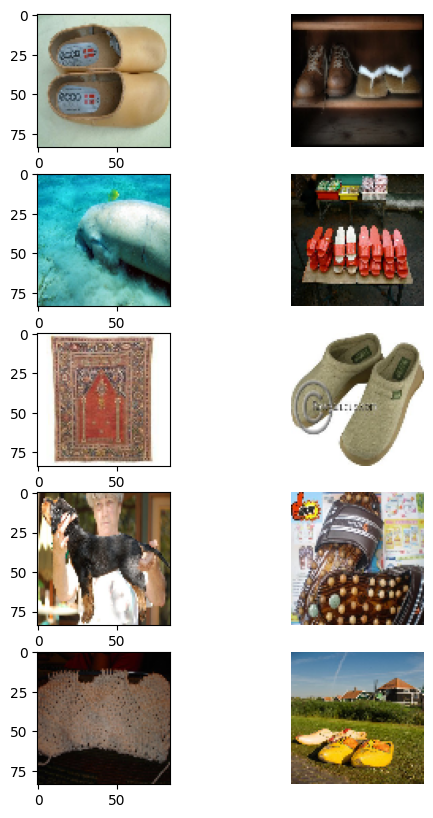

In [ ]:
#idxx=random.sample(list(y_test), 5)
randLayer=np.random.normal(0.1, 0.05,size=(84,84,3))
import cv2

def flip (img):
  img=np.reshape(img, (84,84,3))
  img2= cv2.flip(img, 1)
  return img2 #np.expand_dims(img2, axis=-1)

class Data_GeneratorGeneral(tf.keras.utils.Sequence):

    #def __init__(self, datatype='train', dim=(32,32), n_channels=1, way=20, shot=1, query=1, num_batch=10):
    def __init__(self, datatype='train', dim=(84,84,3), num_per_class=1, n_channels=1, way=20,vway=20, query=1, shot=1, num_batch=10):
        'Initialization'
        global k,idxx
        self.data=x_train
        self.y=y_train

        if(datatype=='val'):
          self.data=x_val
          self.y=y_val

        if(datatype=='test'):
          self.data=x_test
          self.y=y_test

        self.dim = dim
        self.n_channels = n_channels
        #print(num_per_class)
        self.num_batch = num_batch
        self.n_classes = len(self.data)
        self.on_epoch_end()
        self.way = way
        self.vway = vway
        self.shot = shot
        self.query = query
        self.idx2=np.arange(self.way)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.num_batch
    def __getitem__(self,index):
        'Generate one batch of data'

        X_sample, X_query, label= self.__data_generation()
        return [X_sample, X_query], label

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        pass

    def __data_generation(self):
        n_classes=np.unique(self.y)
        X_sample = []; #np.empty((way, shot, *dim))
        X_query = [] #np.empty((way, query, *dim))
        label = np.zeros((self.way*self.query,self.way))*0.1 # size 25 * 5
        noise=[]; #label1 = np.ones((self.way*self.query,self.way*self.shot))*0.2
        layr1 = random.sample([0,1,2], 1)[0]
        idx=random.sample(list(self.y), self.way)

        for i in range(self.way):
            X_temp = [];
            sample_idx1 = random.sample(self.y[idx[i]], self.shot)
            for s in range(self.shot):
              img=self.data[sample_idx1[s]]
              X_temp+= [img]
            X_sample.append(X_temp)

            sample_idx2 = random.sample(self.y[idx[i]], self.query)
            for q in range(self.query):
                img1=self.data[sample_idx2[q]]
                #img1[:,:,layr1] = img1[:,:,layr1] + randLayer[:,:,layr1]
                X_tempp=[]
                X_tempp += [img1]
                # #img2= generator1(np.reshape(flip(img)*(1-mask)+ Noise*mask, (1,84,84,3)))[0].numpy()
                X_tempp += [flip(img1)]
                X_query.append(X_tempp)
                #X_query.append([self.data[matchInd[sample_idx1[s]]]])
                label[i*self.query+q,i]= 1

        return np.array(X_sample), np.array(X_query),label #np.concatenate((label,label),axis=0)

train_way = 5
val_way = 5
shot = 5
query = 5
n=600
#idx = random.sample(list(y_test), train_way)
val_loader = Data_GeneratorGeneral(way=train_way, vway=val_way, datatype='train', num_per_class=n,shot=shot,query=query, num_batch=2)
# print(val_loader[1])
(x,y),z = val_loader[0]
print(x.shape,y.shape,z.shape,z)
# print(z)
(img1,img2),z=val_loader[1]
fig = plt.figure(figsize=(6, 10))

for j in range(5):
    plt.subplot(5,2,2*j+1)
    plt.imshow(img1[j,0,:, :,:] )
    plt.subplot(5,2,2*j+2)
    plt.imshow(img2[j,0,:, :,:] )
    plt.axis('off')
plt.show()
#[4 1 3 2 0]

In [ ]:
print(x.shape,y.shape,z.shape)

(5, 5, 84, 84, 3) (25, 1, 84, 84, 3) (25, 5)


In [ ]:
z

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

(5, 2, 84, 84, 3) (10, 1, 84, 84, 3) (10, 5)
[[0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


<ipython-input-13-4d36dbf67e39>:99: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5,p,p*j+1)


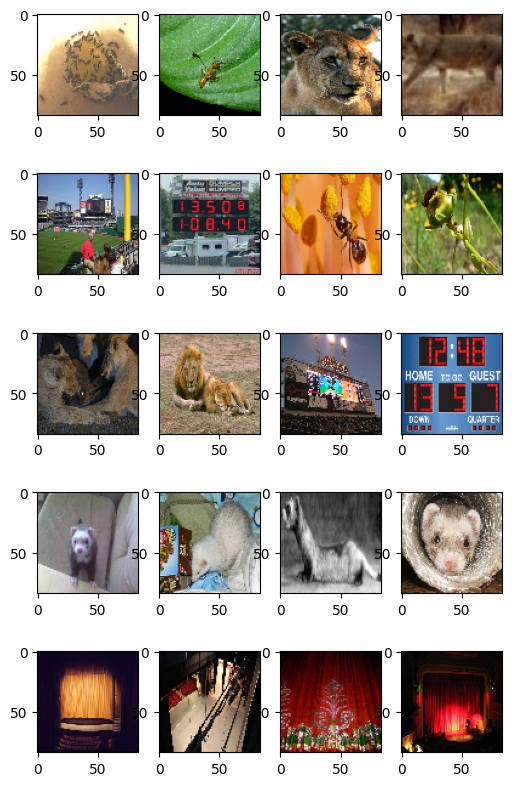

In [ ]:

idxx=random.sample(list(y_test), 5)

import cv2
def flip (img):
  img=np.reshape(img, (84,84,3))
  img2= cv2.flip(img, 1)
  return img2 #np.expand_dims(img2, axis=-1)

class Data_GeneratorRaviLabel(tf.keras.utils.Sequence):

    #def __init__(self, datatype='train', dim=(32,32), n_channels=1, way=20, shot=1, query=1, num_batch=10):
    def __init__(self, datatype='train', dim=(84,84,3), num_per_class=1, n_channels=1, way=20,vway=20, query=1, shot=1, num_batch=10):
        'Initialization'
        global k,idxx
        self.data=x_train
        self.y=y_train

        if(datatype=='val'):
          self.data=x_val
          self.y=y_val

        if(datatype=='test'):
          self.data=x_test
          self.y=y_test

        self.dim = dim
        self.n_channels = n_channels
        #print(num_per_class)
        self.num_batch = num_batch
        self.n_classes = len(self.data)
        self.on_epoch_end()
        self.way = way
        self.vway = vway
        self.shot = shot
        self.query = query

    def __len__(self):
        'Denotes the number of batches per epoch'
        return self.num_batch
    def __getitem__(self,index):
        'Generate one batch of data'
        X_sample, X_query, label = self.__data_generation()
        return [X_sample, X_query], label

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        pass

    def __data_generation(self):
        n_classes=np.unique(self.y)
        X_sample = []; #np.empty((way, shot, *dim))
        X_query = [] #np.empty((way, query, *dim))
        label = np.zeros((self.way*self.query,self.way))
        #label = np.zeros((self.vway,self.way))
        #label = -0.0001*np.ones((self.vway,self.way))

        idx=random.sample(list(self.y), self.way)

        for i in range(self.way):
            X_temp = [];
            sample_idx1 = random.sample(self.y[idx[i]], self.shot)
            for s in range(self.shot):
              X_temp+= [self.data[sample_idx1[s]]]
              #X_temp+= [flip(self.data[sample_idx1[s]])]
            X_sample.append(X_temp)

        idx2 =np.arange(self.way); np.random.shuffle(idx2)
        # shuffle th order of classes to prevent any relations b/w order of classes

        for j in range(self.vway):
          sample_idx2 = random.sample(self.y[idx[idx2[j]]], self.query)
          for q in range(self.query):
              img=self.data[sample_idx2[q]]
              X_tempp=[]
              X_tempp+= [img]
              #X_tempp+= [flip(img)]
              X_query.append(X_tempp)
              #k=np.argwhere(index1 == idx2[j])
              label[j*self.query+q,idx2[j]]= 1


        return np.array(X_sample), np.array(X_query),label #np.concatenate((label,label),axis=0)

train_way = 5
val_way = 5
query = 2
shot = 2
n=600
val_loader = Data_GeneratorRaviLabel(way=train_way, vway=val_way, datatype='test', num_per_class=n,shot=shot,query=query, num_batch=10)

(x,y),z = val_loader[0]
print(x.shape,y.shape,z.shape)
print(z)

fig = plt.figure(figsize=(6, 10))
plt.axis('off')
p=4
for j in range(5):
    plt.subplot(5,p,p*j+1)
    plt.imshow(x[j,0, :, :,:] )

    plt.subplot(5,p,p*j+2)
    plt.imshow(x[j,1, :, :,:] )

    plt.subplot(5,p,p*j+3)
    plt.imshow(y[2*j, 0,:, :,:] )

    plt.subplot(5,p,p*j+4)
    plt.imshow(y[2*j+1,0,:, :,:] )
plt.show()


In [ ]:
def conv_net(dim):
    convnet = Sequential()
    for i in range(4):
        convnet.add(Conv2D(64,(3,3),padding='same',input_shape=dim))
        convnet.add(BatchNormalization())
        convnet.add(layers.ReLU())
        convnet.add(MaxPooling2D())
    convnet.add(Flatten())
    #convnet.add(Dense(100, activation='sigmoid'))

    return convnet
conv = conv_net((84,84,3))
print(conv.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 84, 84, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 84, 84, 64)        256       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 84, 84, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 42, 42, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 42, 42, 64)        2

# protonet

In [ ]:

histw = np.load('Model/without_self_attention_history_file.npy',allow_pickle='TRUE').item()

In [ ]:
print(histw.history['val_accuracy'])
print(histw.history['accuracy'])
print(histw.history['loss'])

[0.4075999855995178, 0.4291999936103821, 0.4447999894618988, 0.4611999988555908, 0.4740000069141388, 0.4560000002384186, 0.5063999891281128, 0.49480000138282776, 0.5040000081062317, 0.5188000202178955, 0.5012000203132629, 0.4984000027179718, 0.5152000188827515, 0.5307999849319458, 0.5235999822616577, 0.5404000282287598, 0.5508000254631042, 0.4927999973297119, 0.5504000186920166, 0.5580000281333923, 0.5627999901771545, 0.5252000093460083, 0.548799991607666, 0.5228000283241272, 0.5564000010490417, 0.5680000185966492, 0.5616000294685364, 0.5924000144004822, 0.5339999794960022, 0.569599986076355, 0.5491999983787537, 0.5759999752044678, 0.5564000010490417, 0.5824000239372253, 0.5952000021934509, 0.5580000281333923, 0.5691999793052673, 0.5824000239372253, 0.5784000158309937, 0.5795999765396118, 0.5784000158309937, 0.5831999778747559, 0.5820000171661377, 0.5663999915122986, 0.5740000009536743, 0.5740000009536743, 0.602400004863739, 0.5879999995231628, 0.6043999791145325, 0.6011999845504761]
[

# plot

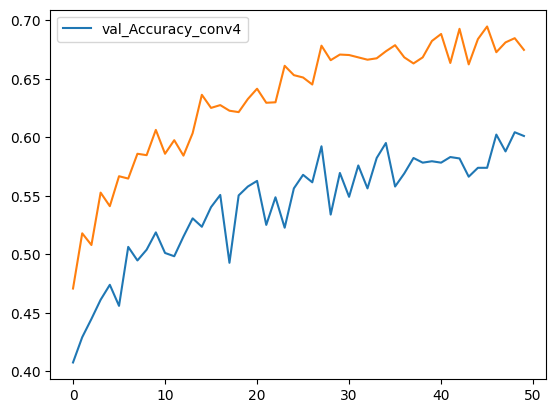

In [ ]:


plt.plot(histw.history['val_accuracy'])

plt.plot(histw.history['accuracy'])

plt.legend(["val_Accuracy_conv4"])

plt.show()

In [ ]:
#@keras.saving.register_keras_serializable()

hists = np.load('Model/new_npy_file.npy',allow_pickle='TRUE').item()

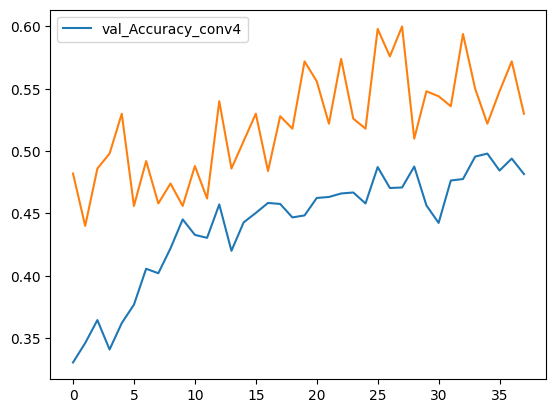

In [ ]:

plt.plot(hists.history['val_accuracy'])

plt.plot(hists.history['accuracy'])

plt.legend(["val_Accuracy_conv4"])

plt.show()

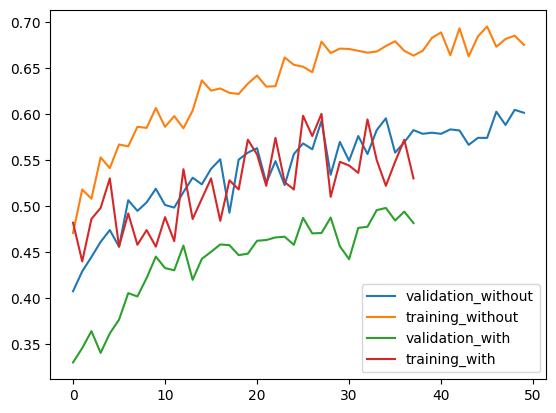

In [ ]:
plt.plot(histw.history['val_accuracy'] , label='validation_without')
plt.plot(histw.history['accuracy'] , label='training_without')
plt.plot(hists.history['val_accuracy'] , label='validation_with')
plt.plot(hists.history['accuracy'] , label='training_with')
plt.legend()
plt.show()


# testing

In [ ]:
model= load_model('Model/ModelFile.h5')

train_way = 5
shot = 5
query=shot
val_way=train_way
n=600

val_loader= Data_GeneratorGeneral(way=train_way, vway=val_way, datatype='val', num_per_class=n,shot=shot,query=query, num_batch=100)
model.evaluate(val_loader)

100/100 [==============================] - 2s 11ms/step - loss: 1.2246 - accuracy: 0.5192


[1.2246404886245728, 0.5192000269889832]

In [ ]:
model= load_model('Model/without_self_attention_Model_file.h5')


# Retaining' With Self Attention

In [ ]:

train_way = 5
shot = 5
query=shot
val_way=train_way
n=600
lr=0.001
dim=(84,84,3)

#import tensorflow_probability as tfp
from tensorflow.keras import callbacks as cb
import tensorflow as tf
cross = tf.keras.losses.CategoricalCrossentropy()

def scheduler(epoch):
    global lr
    if epoch %5== 0:
        lr/= 1.2
    return lr

if __name__ == "__main__":
    conv = convNet(dim)
    #conv= load_model('Model/proto_conv_backbone_miniImagemet_5_5_1000_5.h5')
    conv_5d = TimeDistributed(conv)
    input_shape = (None,84,84,3)

    sample = Input(input_shape)
    out_feature = conv_5d(sample)
    out_feature1 = Lambda(reduce_tensor, name="out_feature1")(out_feature)

    #fs =  self_attention(out_feature1,out_feature1)
    #.........................................................
    inp = Input(input_shape)
    map_feature = conv_5d(inp)
    map_feature1 = Lambda(reduce_tensor , name="map_feature1")(map_feature)


    #fq = self_attention(map_feature1,out_feature1)

    pred = Lambda(proto_dist)([out_feature1, map_feature1])

    #.........................................................

    combine1 = Model([sample,inp], [pred])
    optimizer = Adam(0.001)   #'categorical_crossentropy' contrastive_loss,

    combine1.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    print(combine1.summary())
 #.........................................................................................
    train_loader = Data_GeneratorGeneral(way=train_way, vway=val_way, datatype='train', num_per_class=n,shot=shot,query=query, num_batch=1000)
    val_loader= Data_GeneratorGeneral(way=train_way, vway=val_way, datatype='val', num_per_class=n,shot=shot,query=query, num_batch=100)

    reduce_lr = cb.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4,patience = 15, min_lr = 1e-6)
    stopping = cb.EarlyStopping(monitor='loss', patience=10)
    lr_sched = cb.LearningRateScheduler(scheduler)
    tensorboard = cb.TensorBoard() #Data_GeneratorRaviStratify

    history4 = combine1.fit(train_loader,epochs = 50,steps_per_epoch = 20,validation_data = val_loader, use_multiprocessing=True, workers=8, shuffle=False, callbacks=[ lr_sched,reduce_lr, stopping,tensorboard])

combine1.save('Model/new_h5_file.h5')    #way-shot-qyery

#conv.save('Model/new_npy_file.h5')

np.save('Model/new_npy_file.npy', history4)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, None, 84, 84, 3)]    0         []                            
                                                                                                  
 input_7 (InputLayer)        [(None, None, 84, 84, 3)]    0         []                            
                                                                                                  
 time_distributed_2 (TimeDi  (None, None, 1600)           113600    ['input_6[0][0]',             
 stributed)                                                          'input_7[0][0]']             
                                                                                                  
 out_feature1 (Lambda)       (None, 1600)                 0         ['time_distributed_2[0][

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


20/20 [==============================] - 15s 533ms/step - loss: 2.1016 - accuracy: 0.4820 - val_loss: 1.5412 - val_accuracy: 0.3304 - lr: 8.3333e-04
Epoch 2/50
20/20 [==============================] - 10s 513ms/step - loss: 2.0013 - accuracy: 0.4400 - val_loss: 1.5434 - val_accuracy: 0.3460 - lr: 8.3333e-04
Epoch 3/50
20/20 [==============================] - 11s 506ms/step - loss: 1.7335 - accuracy: 0.4860 - val_loss: 1.5937 - val_accuracy: 0.3644 - lr: 8.3333e-04
Epoch 4/50
20/20 [==============================] - 10s 496ms/step - loss: 1.5408 - accuracy: 0.4980 - val_loss: 1.7815 - val_accuracy: 0.3408 - lr: 8.3333e-04
Epoch 5/50
20/20 [==============================] - 11s 535ms/step - loss: 1.4131 - accuracy: 0.5300 - val_loss: 1.7777 - val_accuracy: 0.3620 - lr: 8.3333e-04
Epoch 6/50
20/20 [==============================] - 10s 502ms/step - loss: 1.6592 - accuracy: 0.4560 - val_loss: 1.7104 - val_accuracy: 0.3768 - lr: 6.9444e-04
Epoch 7/50
20/20 [==============================] -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf

def self_attention(x1,x2):
  attention_weights = tf.nn.softmax(tf.matmul(x1, tf.transpose(x2)))
  weighted_features = tf.matmul(attention_weights,x2) +x1
  return weighted_features


# Extra code


In [ ]:
def inverse_attention(x1):
        a,b,c,d=x1.shape
        x2=tf.reshape(x1,(-1,b*c*d))
        attention_weights = tf.abs(tf.nn.softmax(tf.matmul(x2, tf.transpose(x2))/40)-0.5)
        weighted_features = tf.matmul(attention_weights,x2) # +x1
        return tf.reshape(weighted_features, (-1,b,c,d))

def conv_netAtt(dim):
    convnet = Sequential()
    #convnet.add(tf.keras.layers.RandomFlip( mode=HORIZONTAL_AND_VERTICAL, seed=None, **kwargs))

    for i in range(2):
        convnet.add(tf.keras.layers.Conv2D(64,(3,3),padding='same',input_shape=dim))
        convnet.add(tf.keras.layers.BatchNormalization())
        convnet.add(tf.keras.layers.Activation('relu'))
        convnet.add(tf.keras.layers.MaxPooling2D())
    for i in range(2):
        convnet.add(tf.keras.layers.Conv2D(64,(3,3),padding='same'))
        convnet.add(tf.keras.layers.BatchNormalization())
        convnet.add(tf.keras.layers.Activation('relu'))
        convnet.add(tf.keras.layers.MaxPooling2D())
        #convnet.add(tf.keras.layers.Attention())
        convnet.add(tf.keras.layers.Lambda(inverse_attention))

    convnet.add(tf.keras.layers.Flatten())
    #convnet.add(Normalization(mean=0., variance=1.))
    return convnet
dim=(84,84,3)
model1=conv_netAtt(dim)
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 84, 84, 64)        1792      
                                                                 
 batch_normalization_4 (Bat  (None, 84, 84, 64)        256       
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 84, 84, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 42, 42, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 42, 42, 64)        36928     
                                                                 
 batch_normalization_5 (Bat  (None, 42, 42, 64)       

In [ ]:
class convModel(keras.Model):
    def __init__(self,dim):
        super().__init__(dim)
        self.conv1 = keras.layers.Conv2D(64,(3,3),padding='same',input_shape=dim)
        self.conv2 = keras.layers.Conv2D(64,(3,3),padding='same')
        self.conv3 = keras.layers.Conv2D(64,(3,3),padding='same')
        self.conv4 = keras.layers.Conv2D(64,(3,3),padding='same')
        self.norm1 = tf.keras.layers.BatchNormalization()
        self.norm2 = tf.keras.layers.BatchNormalization()
        self.norm3 = tf.keras.layers.BatchNormalization()
        self.norm4 = tf.keras.layers.BatchNormalization()
        self.pool0 = keras.layers.MaxPooling2D(2,2)
        self.pool2 = keras.layers.MaxPooling2D(2,2)
        self.pool3 = keras.layers.MaxPooling2D(2,2)
        self.pool4 = keras.layers.MaxPooling2D(2,2)
        self.flat = keras.layers.Flatten()

    def inverse_attention(self,x1):
        attention_weights = tf.abs(tf.nn.softmax(tf.matmul(x1, tf.transpose(x1))/40)-0.5)
        weighted_features = tf.matmul(attention_weights,x1) # +x1
        return weighted_features

    def call(self, x):
        #def forward(self, x):
        x = self.pool0(keras.activations.relu(self.norm1(self.conv1(x))))
        x = self.pool2(keras.activations.relu(self.norm2(self.conv2(x))))
        x = tf.keras.layers.Attention()([x, x])
        x = tf.keras.layers.Lambda(self.inverse_attention)(x)
        x = self.pool3(keras.activations.relu(self.norm3(self.conv3(x))))
        x = self.flat( self.pool4(keras.activations.relu(self.norm4(self.conv4(x)))))
        return x

input_shape=(84,84,3)
preConv = convModel(input_shape)
sample = Input(input_shape)
out = preConv(sample)
combine1 = keras.Model(inputs=sample,outputs=out)
optimizer = Adam(0.001)   #'categorical_crossentropy' contrastive_loss,

combine1.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
print(combine1.summary())

ValueError: Exception encountered when calling layer "conv_model" (type convModel).

in user code:

    File "<ipython-input-17-53c65f0d47e2>", line 28, in call  *
        x = tf.keras.layers.Lambda(self.inverse_attention)(x)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "<ipython-input-17-53c65f0d47e2>", line 19, in inverse_attention
        attention_weights = tf.abs(tf.nn.softmax(tf.matmul(x1, tf.transpose(x1))/40)-0.5)

    ValueError: Exception encountered when calling layer 'lambda' (type Lambda).
    
    Dimensions must be equal, but are 64 and 21 for '{{node conv_model/lambda/MatMul}} = BatchMatMulV2[T=DT_FLOAT, adj_x=false, adj_y=false](conv_model/attention/MatMul_1, conv_model/lambda/transpose)' with input shapes: [?,21,21,64], [64,21,21,?].
    
    Call arguments received by layer 'lambda' (type Lambda):
      • inputs=tf.Tensor(shape=(None, 21, 21, 64), dtype=float32)
      • mask=None
      • training=None


Call arguments received by layer "conv_model" (type convModel):
  • x=tf.Tensor(shape=(None, 84, 84, 3), dtype=float32)

In [ ]:


def get_modelClassify(input_shape=(84,84,3)):
    preConv = preModel(input_shape)
    postConv = postModel((20,20,64))
    #attentionBlock=AttentionBlock(64,  up_factor=2)
    # m3= load_model('Model/conv2211_22classify_miniImagemet.h5')
    # feature_att = tf.keras.models.Model(inputs=m3.input, outputs=m3.layers[-4].output)
    # feature_att.trainable=False

    inputs = layers.Input(shape=input_shape)
    x0=preConv(inputs)
    #mn=tf.reduce_mean(x0, axis=0)
    position_mask = keras.layers.Conv2D(64, (1,1), activation='linear', input_dim=(8,8,1) )(mask)
    xa=postConv(x0)
    # #x1=feature_att(x0);
    # x1=tf.keras.layers.UpSampling2D(size=(4,4))(xa)
    x2=tf.keras.layers.Attention()([x0, xa*position_mask])
    x3=postConv(xa+x2) #


class AttentionBlock(layers.Layer):
    def _init_(self, filters, up_factor=2):
        super(AttentionBlock, self)._init_()
        self.up_factor = up_factor
        self.W_l = layers.Conv2D(filters, kernel_size=1, padding='valid', use_bias=False)
        self.W_g = layers.Conv2D(filters, kernel_size=1, padding='valid', use_bias=False)
        self.phi = layers.Conv2D(filters, kernel_size=1, padding='valid', use_bias=True)
    def call(self, l, g):
        N, C, W, H = l.shape
        l_ = self.W_l(l)
        g_ = self.W_g(g)
        for _ in range(self.up_factor):
            g_ = tf.keras.layers.UpSampling2D(size=(2, 2))(g_)

        output = tf.keras.layers.Attention()([l_, g_])
        return output

In [ ]:
obj = Premodel((84,84,3))
obj.call()


NameError: name 'Premodel' is not defined

# Without Self attention

In [ ]:
train_way = 5
shot = 5
query=shot
val_way=train_way
n=600
lr=0.001
dim=(84,84,3)

#import tensorflow_probability as tfp
from tensorflow.keras import callbacks as cb
import tensorflow as tf
cross = tf.keras.losses.CategoricalCrossentropy()

def scheduler(epoch):
    global lr
    if epoch %5== 0:
        lr/= 1.2
    return lr

if __name__ == "__main__":
    conv = conv_net(dim)
    # conv= load_model('Model/without_proto_conv_backbone_miniImagemet_5_5_1000_5.h5')
    conv_5d = TimeDistributed(conv)
    input_shape = (None,84,84,3)

    sample = Input(input_shape)
    out_feature = conv_5d(sample)
    out_feature1 = Lambda(reduce_tensor, name="out_feature1")(out_feature)

    # fs =  self_attention(out_feature1,out_feature1)
    #.........................................................
    inp = Input(input_shape)
    map_feature = conv_5d(inp)
    map_feature1 = Lambda(reduce_tensor , name="map_feature1")(map_feature)

#     fq = self_attention(map_feature1,out_feature1)

    pred = Lambda(proto_dist)([out_feature1,map_feature1])

    #.........................................................

    combine1 = Model([sample,inp], [pred])
    optimizer = Adam(0.001)   #'categorical_crossentropy' contrastive_loss,

    combine1.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    print(combine1.summary())
 #.........................................................................................
    train_loader = Data_GeneratorGeneral(way=train_way, vway=val_way, datatype='train', num_per_class=n,shot=shot,query=query, num_batch=1000)
    val_loader= Data_GeneratorGeneral(way=train_way, vway=val_way, datatype='val', num_per_class=n,shot=shot,query=query, num_batch=100)

    reduce_lr = cb.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4,patience = 15, min_lr = 1e-6)
    stopping = cb.EarlyStopping(monitor='loss', patience=20)
    lr_sched = cb.LearningRateScheduler(scheduler)
    tensorboard = cb.TensorBoard() #Data_GeneratorRaviStratify

    history4 = combine1.fit(train_loader,epochs = 50,steps_per_epoch = 500,validation_data = val_loader, use_multiprocessing=True,workers=8, shuffle=False, callbacks=[ lr_sched,reduce_lr, stopping,tensorboard])

combine1.save('Model/without_self_attention_Model_file.h5')    #way-shot-qyery

# conv.save('Model/without_proto_conv_backbone_miniImagemet_5_5_1000_5.h5')
np.save('Model/without_self_attention_history_file.npy', history4)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, 84, 84, 3)]    0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, None, 84, 84, 3)]    0         []                            
                                                                                                  
 time_distributed_1 (TimeDi  (None, None, 1600)           113600    ['input_3[0][0]',             
 stributed)                                                          'input_4[0][0]']             
                                                                                                  
 out_feature1 (Lambda)       (None, 1600)                 0         ['time_distributed_1[0][

#Test


In [ ]:


train_way = 5
shot = 5
query=shot
val_way=train_way
n=600
lr=0.001
dim=(84,84,3)

#import tensorflow_probability as tfp
from tensorflow.keras import callbacks as cb
import tensorflow as tf
cross = tf.keras.losses.CategoricalCrossentropy()

def scheduler(epoch):
    global lr
    if epoch %5== 0:
        lr/= 1.2
    return lr

if __name__ == "__main__":
    conv = convNet((84,84,3))
    #conv= load_model('Model/proto_conv_backbone_miniImagemet_5_5_1000_5.h5')
    conv_5d = TimeDistributed(conv)
    input_shape = (None,84,84,3)

    sample =  get_modelClassify(input_shape)
    out_feature = conv.call(sample)
    out_feature1 = Lambda(reduce_tensor, name="out_feature1")(out_feature)

    se_lf = AttentionBlock();

    fs =  self_attention(out_feature1,out_feature1)
    #.........................................................
    inp = get_modelClassify(input_shape)
    map_feature = conv.call(inp)

    map_feature1 = Lambda(reduce_tensor , name="map_feature1")(map_feature)

    fq = self_attention(map_feature1,out_feature1)

    pred = Lambda(proto_dist)([fs, fq])

    #.........................................................

    combine1 = Model([sample,inp], [pred])
    optimizer = Adam(0.001)   #'categorical_crossentropy' contrastive_loss,

    combine1.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    print(combine1.summary())
 #.........................................................................................
    train_loader = Data_GeneratorGeneral(way=train_way, vway=val_way, datatype='train', num_per_class=n,shot=shot,query=query, num_batch=1000)
    val_loader= Data_GeneratorGeneral(way=train_way, vway=val_way, datatype='val', num_per_class=n,shot=shot,query=query, num_batch=100)

    reduce_lr = cb.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4,patience = 15, min_lr = 1e-6)
    stopping = cb.EarlyStopping(monitor='loss', patience=20)
    lr_sched = cb.LearningRateScheduler(scheduler)
    tensorboard = cb.TensorBoard() #Data_GeneratorRaviStratify

    history4 = combine1.fit(train_loader,epochs = 100,steps_per_epoch = 500,validation_data = val_loader, use_multiprocessing=True,workers=8, shuffle=False, callbacks=[ lr_sched,reduce_lr, stopping,tensorboard])

combine1.save('Model/proto_conv4_miniImagemet_5_5_1000.h5')    #way-shot-qyery

conv.save('Model/proto_conv_backbone_miniImagemet_5_5_1000_5.npy')

Pavani's Code


In [ ]:


from tensorflow.keras.layers import Layer
from keras.backend import softmax
import keras

@keras.saving.register_keras_serializable()
class invAttention(Layer):
    def _init_(self, **kwargs):
        super(invAttention, self)._init_(**kwargs)

    def call(self, x):
        x1 = tf.transpose(x, perm=(0, 2, 1, 3))
        scores = tf.matmul(x, x1, transpose_b=True) / 40.0
        k = tf.random.uniform(shape=[1], minval=0.1, maxval=0.2, dtype=tf.float32)
        # Computing the weights by a softmax operation
        weights = softmax(tf.abs(scores - k))
        # Computing the attention by a weighted sum of the value vectors
        return tf.matmul(weights, x1)

class selfAttention(Layer):
    def _init_(self, **kwargs):
        super(selfAttention, self)._init_(**kwargs)

    def call(self, x):
        x1 = tf.transpose(x, perm=(0, 2, 1, 3))
        scores = tf.matmul(x, x1, transpose_b=True) / 40.0
        # Computing the weights by a softmax operation
        weights = softmax(scores)
        # Computing the attention by a weighted sum of the value vectors
        return matmul(weights, x1)

def convNet(dim):
    convnet = Sequential()
    for i in range(3):
        convnet.add(keras.layers.Conv2D(64,(3,3),padding='same',input_shape=dim))
        convnet.add(BatchNormalization())
        convnet.add(Activation('relu'))
        convnet.add(MaxPooling2D())
    #convnet.add(selfAttention())
    convnet.add(invAttention())
    convnet.add(keras.layers.Conv2D(64,(3,3),padding='same'))
    convnet.add(BatchNormalization())
    convnet.add(Activation('relu'))
    convnet.add(MaxPooling2D())
    convnet.add(Flatten())
    #convnet.add(Normalization(mean=0., variance=1.))
    return convnet
md1= convNet((84,84,3))
print(md1.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 84, 84, 64)        1792      
                                                                 
 batch_normalization_27 (Ba  (None, 84, 84, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_19 (Activation)  (None, 84, 84, 64)        0         
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 42, 42, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 42, 42, 64)        36928     
                                                                 
 batch_normalization_28 (Ba  (None, 42, 42, 64)       

# Lavanya's Code

In [ ]:
class selfAttention(Layer):
    def _init_(self, **kwargs):
        super(selfAttention, self)._init_(**kwargs)

    def call(self, x):
        out = tf.keras.layers.Attention()([x, x])
        return out
md1= conv_net((84,84,3))
print(md1.summary())
def convNet(dim):
    convnet = Sequential()
    for i in range(3):
        convnet.add(keras.layers.Conv2D(64,(3,3),padding='same',input_shape=dim))
        convnet.add(BatchNormalization())
        convnet.add(Activation('relu'))
        convnet.add(MaxPooling2D())
    #convnet.add(selfAttention())
    convnet.add(keras.layers.Conv2D(64,(3,3),padding='same'))
    convnet.add(BatchNormalization())
    convnet.add(Activation('relu'))
    convnet.add(MaxPooling2D())
    convnet.add(Flatten())
    return convnet

input_shape=(84,84,3)
preConv = convModel(input_shape)
inputs = layers.Input(shape=input_shape)
out1 = preConv(inputs)
out2 = tf.keras.layers.Attention()([out1, out1])
output = tf.keras.layers.Dense(2, activation="softmax")(out2)
model = keras.Model(inputs=inputs, outputs=output)

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 84, 84, 64)        1792      
                                                                 
 batch_normalization_12 (Ba  (None, 84, 84, 64)        256       
 tchNormalization)                                               
                                                                 
 re_lu_4 (ReLU)              (None, 84, 84, 64)        0         
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 42, 42, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 42, 42, 64)        36928     
                                                                 
 batch_normalization_13 (Ba  (None, 42, 42, 64)       

NameError: name 'convModel' is not defined